In [59]:
import os
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils

import cv2
import PIL
import matplotlib.pyplot as plt

from my_utils import data, models
from my_utils.utils import save_model, check_accuracy, train
from my_utils.vis import grid_vis

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
UseGPU = torch.cuda.is_available()
device = torch.device("cuda" if UseGPU else "cpu")
print(f"Using {device} now!")
if UseGPU:
    print(f"CUDA version: {torch.cuda_version}")

Using cuda now!
CUDA version: 11.3


In [3]:
batch_size = 128
fig_resize = 32
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize))
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': False,        # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [4]:
# 制作二进制数据集
train_data = data.MyDataset('Datasets/polygons_unfilled_32/train', transform=T)
train_loader = DataLoader(train_data, **loader_kwargs)

val_data = data.MyDataset('Datasets/polygons_unfilled_32/val', transform=T)
val_loader = DataLoader(val_data, **loader_kwargs)

test_data = data.MyDataset('Datasets/polygons_unfilled_32/test', transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [5]:
sample_step = 10

small_train_data = Subset(train_data, torch.arange(0, len(train_data) - 1, sample_step))
small_train_loader = DataLoader(small_train_data, **loader_kwargs)

small_val_data = Subset(val_data, torch.arange(0, len(val_data) - 1, sample_step))
small_val_loader = DataLoader(small_val_data, **loader_kwargs)

In [6]:
# check data before training!
img, label = train_data[0]
print(len(train_data), '\t', img.shape)
imgs, labels = next(iter(train_loader))
print(len(train_loader), '\t', imgs.shape)

img, label = val_data[0]
print(len(val_data), '\t', img.shape)
imgs, labels = next(iter(val_loader))
print(len(val_loader), '\t', imgs.shape)

40000 	 torch.Size([1, 32, 32])
312 	 torch.Size([128, 1, 32, 32])
8000 	 torch.Size([1, 32, 32])
62 	 torch.Size([128, 1, 32, 32])


In [56]:
val_loader.batch_size

128

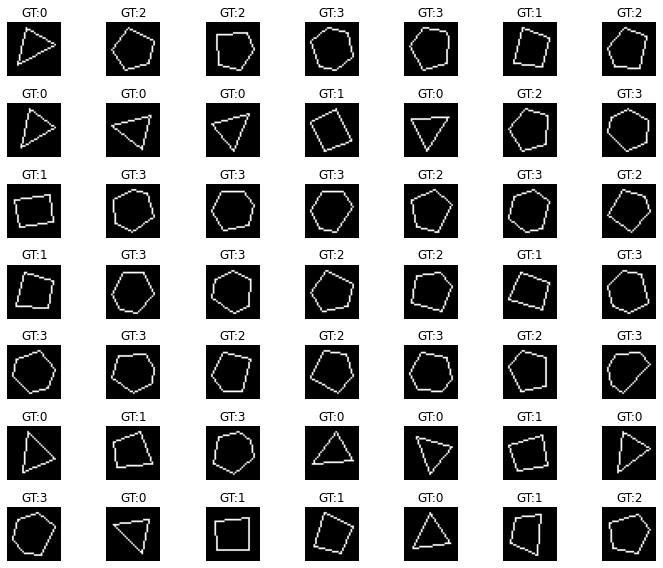

In [46]:
grid_vis(test_loader, 7)

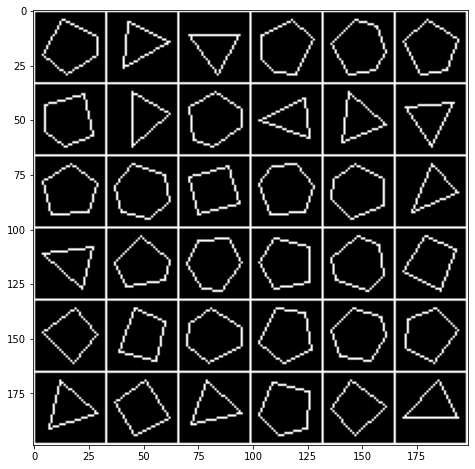

In [13]:
imgs_grid = tvutils.make_grid(imgs[:36], nrow=6, padding=1, pad_value=1)
plt.imshow(imgs_grid.permute(1,2,0))
plt.show()

In [15]:
model = models.my_ConvNeXt(in_chans=1, num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.05)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
loss_func = nn.CrossEntropyLoss()

In [12]:
# copy the following line to prompt line!
# tensorboard --logdir runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [16]:
writer = SummaryWriter()
# writer.add_graph(model, torch.rand([1, 1, 32, 32], device=device))

In [17]:
# reset train history
batch_step = 0

In [18]:
# Train and test!

check_loaders = {'train':small_train_loader,
                 'val':small_val_loader}

In [19]:
batch_step = train(model, optimizer, scheduler, loss_func, train_loader,
                   check_fn=check_accuracy,
                   check_loaders=check_loaders,
                   batch_step=batch_step, epochs=60, log_every=50)

Epoch: 1 [0/40000 (0%)]	Loss: 1.39900	Val acc: 24.5%
Epoch: 1 [6400/40000 (16%)]	Loss: 1.36389	Val acc: 25.4%
Epoch: 1 [12800/40000 (32%)]	Loss: 1.32822	Val acc: 29.0%
Epoch: 1 [19200/40000 (48%)]	Loss: 1.31781	Val acc: 35.5%
Epoch: 1 [25600/40000 (64%)]	Loss: 1.28268	Val acc: 35.8%
Epoch: 1 [32000/40000 (80%)]	Loss: 1.27840	Val acc: 36.2%
Epoch: 1 [38400/40000 (96%)]	Loss: 1.30244	Val acc: 36.3%
====> Epoch: 1	Time: 13.020544052124023s
Epoch: 2 [0/40000 (0%)]	Loss: 1.26045	Val acc: 36.8%
Epoch: 2 [6400/40000 (16%)]	Loss: 1.24142	Val acc: 40.2%
Epoch: 2 [12800/40000 (32%)]	Loss: 1.21570	Val acc: 42.1%
Epoch: 2 [19200/40000 (48%)]	Loss: 1.17836	Val acc: 43.9%
Epoch: 2 [25600/40000 (64%)]	Loss: 1.15490	Val acc: 43.1%
Epoch: 2 [32000/40000 (80%)]	Loss: 1.15211	Val acc: 44.7%
Epoch: 2 [38400/40000 (96%)]	Loss: 1.13526	Val acc: 50.4%
====> Epoch: 2	Time: 12.461067199707031s
Epoch: 3 [0/40000 (0%)]	Loss: 1.13778	Val acc: 51.2%
Epoch: 3 [6400/40000 (16%)]	Loss: 1.11633	Val acc: 50.5%
Epoch: 3

In [26]:
writer.close()

In [20]:
model.eval()
test_acc = check_accuracy(model, test_loader)
print('Test accuracy is : %.2f%%' % (100. * test_acc))

Test accuracy is : 90.68%


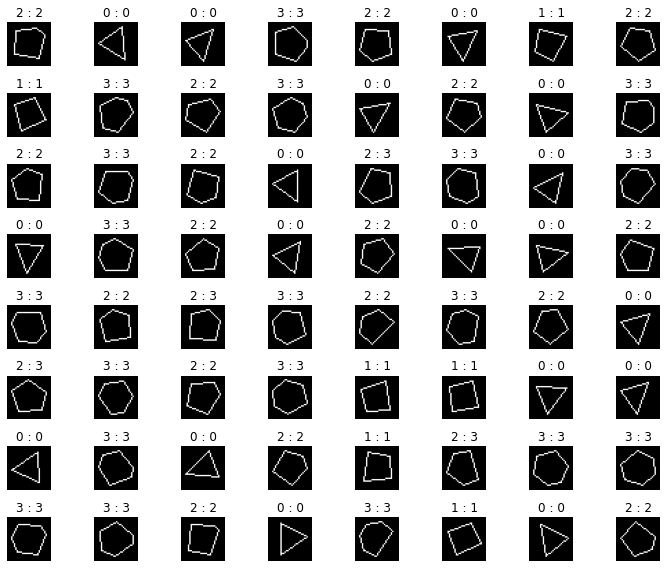

In [21]:
grid_vis(test_loader, 8, model)

In [22]:
# Save model
save_model(model, 'myconvnext', optimizer, acc=90)

Model parameters:
connection_layers.0.weight:	 torch.Size([8, 1])
connection_layers.0.bias:	 torch.Size([8])
connection_layers.1.weight:	 torch.Size([16, 8])
connection_layers.1.bias:	 torch.Size([16])
connection_layers.2.weight:	 torch.Size([32, 16])
connection_layers.2.bias:	 torch.Size([32])
norm_layers.0.weight:	 torch.Size([8])
norm_layers.0.bias:	 torch.Size([8])
norm_layers.0.running_mean:	 torch.Size([8])
norm_layers.0.running_var:	 torch.Size([8])
norm_layers.0.num_batches_tracked:	 torch.Size([])
norm_layers.1.weight:	 torch.Size([8])
norm_layers.1.bias:	 torch.Size([8])
norm_layers.1.running_mean:	 torch.Size([8])
norm_layers.1.running_var:	 torch.Size([8])
norm_layers.1.num_batches_tracked:	 torch.Size([])
norm_layers.2.weight:	 torch.Size([16])
norm_layers.2.bias:	 torch.Size([16])
norm_layers.2.running_mean:	 torch.Size([16])
norm_layers.2.running_var:	 torch.Size([16])
norm_layers.2.num_batches_tracked:	 torch.Size([])
stages.0.0.gamma:	 torch.Size([8])
stages.0.0.dwconv

In [57]:
# reload modal paras from saved .pt file
new_model = models.my_ConvNeXt()

new_model.to(device)
new_optimizer = optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-5, weight_decay=0.1)

save_path = 'saved_models/97_polygen_myconvnext_2022_01_21_19_58_50.pt'
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint["model_paras"])
new_optimizer.load_state_dict(checkpoint["optim_paras"])

In [28]:
new_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(new_optimizer, T_0=1, T_mult=2)

In [62]:
new_model.eval()
check_accuracy(new_model, test_loader)

Test accuracy is : 97.00%	Infer time: 4.68831992149353


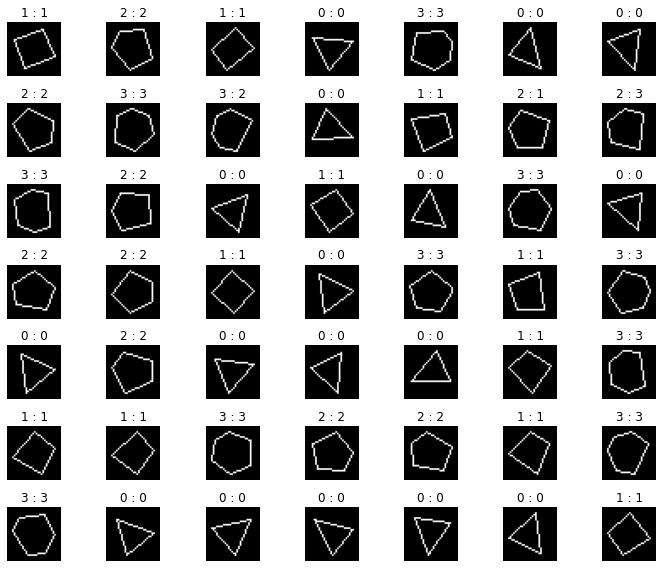

In [64]:
grid_vis(test_loader, 7, new_model)